# Data Ingestion

Now that we have a set of PDFs, we need to ingest them into a usable, useful format. In this notebook, we'll take our folder of PDFs and ingest with OCR, along with some basic checks and visualizations.

Our steps in this notebook will be:
- Process and ingest all PDFs with tesseract for optical character recognition (OCR)
- Perform initial basic clustering to visualize the document variation across our corpus sample
- Do some basic quality assessments of the results of OCR ingestion
- Explore a few specific poor quality vs high quality examples, for comparison of OCR quality at the document level

<br/>

*Note: With the purpose to inject more variability into our corpus, we have added a number of html files into the data_raw folder from the SEC Edgar website. We will include these documents in the steps going forward.*

<br/>

<br/>
<br/>

## Dependencies & Configuations

First, let's load in the various required packages that we will need

In [1]:
import fitz
import pandas as pd
import pytesseract
from pytesseract import Output
from PIL import Image
import glob
import spacy
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Set, Dict, Tuple
from dotenv import load_dotenv
from bs4 import BeautifulSoup

<br/>

Set home directory - we suggest making this the data folder in the repo:

In [2]:
load_dotenv()
HOME_DIRECTORY = os.getenv("HOME_DIRECTORY")

<br/>

## Ingest and OCR documents

First, we will run OCR over each PDF document using tesseract, and save the OCR results to txt files. 

Though it's not critical, we are going to run OCR with text position elements, which we will also save to file. Though we're not sure if we will use this information downstream, because OCR can be a proceesing bottleneck, we only want to run it once, and the text position elements are a small overhead to this process.

Additionally, as noted, we're also bringing additional html files for processing from SEC Edgar to ensure we have reasonable variability in our corpus. We'll include these in the same ingestion process in this section, though OCR won't be necessary for the html files.

#### First, the PDF processing:

In [3]:
def pdf_to_text_with_ocr(pdf_path: str, output_txt_path: str):
    '''
    Behavior:  The filename of the PDF is used to create two automatically saved output
    files - a text file and an Excel file - to the designated folder. The same name of the
    PDF is used for the names of these files. Any errors are printed to the screen.
    
    Parameters:
    - pdf_path (str): filepath to the PDF on local disk
    - output_txt_path (str): filepath to the folder in which to save
    
    Returns: None
    
    ## Example usage:
    # pdf_file_path = os.path.join(HOME_DIRECTORY, "test.pdf")
    # output_text_file_path = os.path.join(HOME_DIRECTORY, text_files)
    # pdf_to_text_with_ocr(pdf_file_path, output_text_file_path)
    '''
    try:
        # Open the PDF file using PyMuPDF
        pdf_document = fitz.open(pdf_path)
        pdf_name = os.path.basename(pdf_path)+'.txt'
        excel_name = os.path.basename(pdf_path)+'.xlsx'
    
        # Initialize an empty string to store the text content
        text_content = ""
        # Initialize an empty pandas db to store positions
        positions_df = pd.DataFrame()
    
        # Iterate through each page in the PDF
        for page_num in range(pdf_document.page_count):
            # Get the current page
            page = pdf_document[page_num]
    
            # Render the page as an image
            image = page.get_pixmap()
            img = Image.frombytes("RGB", (image.width, image.height), image.samples)
    
            # Perform OCR using pytesseract on the image
            page_text = pytesseract.image_to_string(img, lang='eng')
            positions = pytesseract.image_to_data(img, output_type=Output.DATAFRAME)
            
            # Append the extracted text to the overall content
            text_content += page_text
            positions_df = pd.concat([positions_df, positions], ignore_index=True)
    
        # Save the text content to a text file
        with open(os.path.join(output_txt_path, pdf_name), 'w', encoding='utf-8') as txt_file:
            txt_file.write(text_content)
    
        # Save positions to spreadsheet
        positions_df.to_excel(os.path.join(output_txt_path, excel_name), index=False)
    
        # Print a success message
        print(f"OCR completed successfully. Text saved at: {os.path.join(output_txt_path, pdf_name)}")

    except OSError as err:
        print("OS error:", err)
    except ValueError as err:
        print("URL or folder is invalid:", err)
    except Exception as err:
        print(f"Unexpected {err=}, {type(err)=}")
        raise

<br/>

Now, let's pull all the names of the PDFs we want to ingest and process into a list to iterate over:

In [4]:
pdfs = glob.glob(os.path.join(HOME_DIRECTORY, 'data', 'data_raw', '*pdf'))
len(pdfs)

2422

<br/>

Now, let's use our function to kick off OCR processing (**note** this will take a while!) and automatically save the results.

*Note:* Again, alternatively, the OCR data is available on the Google Drive to pull into your local instance.

In [5]:
for i, pdf in enumerate(pdfs):
    pdf_to_text_with_ocr(pdf, os.path.join(HOME_DIRECTORY, 'data', 'data_text'))

Unexpected err=ModuleNotFoundError("No module named 'openpyxl'"), type(err)=<class 'ModuleNotFoundError'>


ModuleNotFoundError: No module named 'openpyxl'

<br/><br/>

#### Next, the HTML processing:

As noted, we have supplemented the dataset by adding additional data from SEC Edgar into the "data_raw" folder. Below, we'll read in this data and add additional .txt files into our "data_text" folder.

In [8]:
def pull_text_from_html(file_list, output_dir: str):
    """
    Extracts and cleans text content from a list of HTML files.

    This function iterates through a list of file paths, attempts to open each file,
    and handles potential encoding errors by first trying 'windows-1252' and then
    'utf-8'. It then uses BeautifulSoup to parse the HTML content and extract
    all text, joining it into a single, clean string.

    Args:
        file_list (list): A list of file paths to HTML documents.

    Returns:
        list: A list of strings, where each string contains the cleaned text
              content from the corresponding HTML file.
    """
    clean_texts = []
    
    # Iterate through each file path provided in the list
    for f in file_list:
        html_string = ''  # Initialize an empty string to hold the HTML content
        
        # First, try to open the file using the 'windows-1252' encoding
        try:
            with open(f, 'r', encoding='windows-1252') as file:
                html_string = file.read()
        except Exception as e1:
            print(f'Encoding error with windows-1252 for file {f}: {e1}')
            
            # If 'windows-1252' fails, try 'utf-8' encoding
            try:
                with open(f, 'r', encoding='utf-8') as file:
                    html_string = file.read()
                    print(f'Successfully read file {f} with utf-8 encoding.')
            except Exception as e2:
                print(f'Encoding error with utf-8 for file {f}: {e2}')
                # If both encodings fail, the html_string remains empty, and the loop continues.
                
        # Use BeautifulSoup to parse the HTML and extract all text
        # .stripped_strings removes leading/trailing whitespace and empty strings
        # ' '.join() combines all the extracted strings into one single string
        if html_string:  # Only proceed if we successfully read content
            clean_text = ' '.join(BeautifulSoup(html_string, "html.parser").stripped_strings)
            clean_texts.append(clean_text)
            
            # Save the text content to a text file
            with open(os.path.join(output_dir, os.path.basename(f)) + '.txt', 'w', encoding='utf-8') as t:
                t.write(clean_text)
                print('Success', f)

        else:
            clean_texts.append(None) # Append None or an empty string if file couldn't be read
            print('Failure', f)
    return clean_texts

In [7]:
htmls = glob.glob(os.path.join(HOME_DIRECTORY, 'data', 'data_raw', '*.htm*')) ## get both htm and html files
len(htmls)

1006

In [9]:
texts = pull_text_from_html(htmls, os.path.join(HOME_DIRECTORY, 'data', 'data_text'))

Success /Users/rachelwagner-kaiser/Documents/NLPBook/code-test-repo/data/data_raw/Kindlyex10-1.htm
Success /Users/rachelwagner-kaiser/Documents/NLPBook/code-test-repo/data/data_raw/stuartcobbarconsultingagre.html
Success /Users/rachelwagner-kaiser/Documents/NLPBook/code-test-repo/data/data_raw/mergeragreement.html
Encoding error with windows-1252 for file /Users/rachelwagner-kaiser/Documents/NLPBook/code-test-repo/data/data_raw/mxct-20250331xex10d1.htm: 'charmap' codec can't decode byte 0x9d in position 1331: character maps to <undefined>
Successfully read file /Users/rachelwagner-kaiser/Documents/NLPBook/code-test-repo/data/data_raw/mxct-20250331xex10d1.htm with utf-8 encoding.
Success /Users/rachelwagner-kaiser/Documents/NLPBook/code-test-repo/data/data_raw/mxct-20250331xex10d1.htm
Success /Users/rachelwagner-kaiser/Documents/NLPBook/code-test-repo/data/data_raw/bloomex10-3.htm


<br/><br/><br/>

## Cluster and Visualize Corpus

Next, let's take our OCR output and quickly visualize the results of OCR. To do that, we'll write a few functions to pull in the OCRd text from file, and run a quick term frequency inverse document frequency (TFIDF) vectorization to get a quick set of features that represent each document. Then, we'll use a K-Means clustering to cluster the documents, and a simple principal component analysis (PCA) to visualize the clusters.

We're going to largely use the default settings for TFIDF vectorization and K-Means clustering and our PCA, since this is for a quick visualization of our ingested data, rather than for a deep analysis.

In [12]:
def read_text_files(folder_path: str):
    """
    Behavior: Read text from a folder of .txt files, ignoring other file types

    Parameters:
    - folder_path (str): Path to the folder containing .txt files.

    Returns:
    - texts (list): List of strings, where each string is the content of a text file.
    """
    texts = []
    files = []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(".txt"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
                texts.append(text)
                files.append(filename)
        # else:
        #     print('Skipping', filename, ', which is not a text file and will be excluded from analysis.')
    return texts, files
    
def perform_clustering(texts: List, X = None, num_clusters: int = 3):
    """
    Behavior: Perform unsupervised clustering on the document text.

    Parameters:
    - texts (list): List of strings, where each string is the content of a document.
    - num_clusters (int): Number of clusters for KMeans algorithm.

    Returns:
    - labels (list): List of cluster labels assigned to each document.
    """
    # Use TfidfVectorizer to convert text into numerical features
    # if X has already been fit, use provided value, else continue with fit
    if X is None:    
        vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=.05, max_features=3000, ngram_range=(1,3))
        X = vectorizer.fit_transform(texts)

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    silhouette_scores = silhouette_score(X, labels)

    return labels, silhouette_scores

def find_knee(texts: List, k_values: range = range(3, 11)):    
    """
    Behavior: Perform unsupervised clustering on the document text.

    Parameters:
    - texts (list): List of strings, where each string is the content of a document.
    - k_values (range): Range of cluster values to test / examine with knee diagram.

    Returns: None
    """
    vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=.05, max_features=3000, ngram_range=(1,3))
    X = vectorizer.fit_transform(texts)

    # Calculating silhouette score for each value of k
    silhouette_scores = []
    for k in k_values:
        labels, silhouette = perform_clustering(texts, X, k)
        silhouette_scores.append(silhouette)
        
    # Plotting the knee plot
    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('# of Clusters (k)')
    plt.ylabel('Silhouette Scores')
    plt.show()
    
def visualize_clusters(texts: List, labels: List):
    """
    Behavior: Visualize the clusters using principal component analysis (PCA).

    Parameters:
    - texts (list): List of strings, where each string is the content of a document.
    - labels (list): List of cluster labels assigned to each document.

    ## Example usage:
    # folder_path = HOME_DIRECTORY
    # texts = read_text_files(os.path.join(HOME_DIRECTORY, 'ocr_text/'))
    # cluster_labels = perform_clustering(texts)
    # visualize_clusters(texts, cluster_labels)
    """
    # Use TfidfVectorizer to convert text into numerical features
    vectorizer = TfidfVectorizer(stop_words='english')
    X = vectorizer.fit_transform(texts)

    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X.toarray())

    # Visualize clusters
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.8)
    plt.title('Document clustering visualization (PCA)')
    plt.xlabel('Principal component 1')
    plt.ylabel('Principal component 2')
    #plt.legend(*scatter.legend_elements(), title='Clusters')
    plt.show()


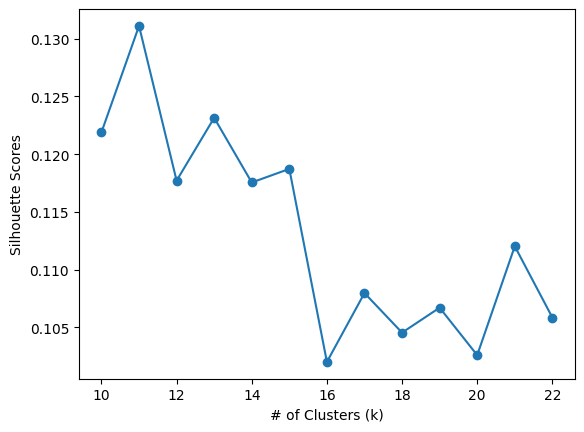

In [13]:
folder_path = os.path.join(HOME_DIRECTORY, "data", "data_text")
texts, filenames = read_text_files(folder_path)

find_knee(texts, range(10, 23, 1))

<br/><br/>

Now that we have our analysis functions set up, let's get a quick visualization of our documents:

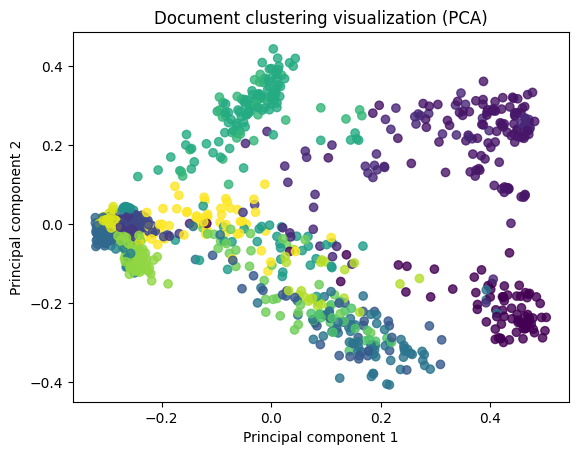

In [14]:
cluster_labels, scores = perform_clustering(texts, num_clusters=19)
visualize_clusters(texts, cluster_labels)

<br/>

We can see that there are a number of distinct clusters that pop out pretty obviously from our corpus. We'll dive into these in a bit more detail.

<br/><br/>

## OCR Quality Assessments

<br/>

Now, let's run some basic metrics to examine quality and range of output. To do this, we'll look at the OCR'd text and check against a reference dictionary (from the spaCy package) to see how often words in the OCR'd text are words we find in a normal dictionary. 

While there will be some proper nouns, acronyms, or other values that we expect will show up in a document of text, if the document quality is high, we expect this to be a fairly small proportion of the text. If the OCR quality is low, we expect to see a higher rate of words with OCR errors (and thus would not show up in a normal dictionary).

We will apply this analysis to both the Chicago Cook County PDFs and the SEC Edgar data. Though only the PDFs went through OCR, we can apply the below checks to both types of data.

In [15]:
def calculate_ocr_quality(texts: List):
    """
    Behavior: Calculate OCR quality scores for a list of texts based on recognized English words.

    Parameters:
    - texts (list): List of OCR-generated texts.

    Returns:
    - ocr_quality_scores (list): List of OCR quality scores ranging from 0 to 1
    """
    nlp = spacy.load("en_core_web_sm")
    ocr_quality_scores = []

    for text in texts:
        doc = nlp(text)
        english_word_count = sum(1 for token in doc if token.is_alpha and token.text.lower() in nlp.vocab)
        total_word_count = len(doc)

        # Calculate OCR quality as the ratio of recognized English words to total words
        quality_score = english_word_count / total_word_count if total_word_count > 0 else 0
        ocr_quality_scores.append(quality_score)

    return ocr_quality_scores

def plot_ocr_quality_histogram(ocr_quality_scores: List):
    """
    Behavior: Plot a histogram of OCR quality scores.

    Parameters:
    - ocr_quality_scores (list): List of OCR quality scores ranging from 0 to 1
    
    Returns: None
    """
    # Check if OCR quality scores are provided
    if not ocr_quality_scores:
        print("Error: No OCR quality scores provided.")
        return

    # Plot the histogram
    plt.hist(ocr_quality_scores, bins=20, range=(0, 1), edgecolor='black', alpha=0.7)
    
    # Set labels and title
    plt.title('OCR Quality Histogram')
    plt.xlabel('OCR Quality Score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

<br/>

Let's now use these functions to examine our overall document quality. 

*Note*: this will take time to run.

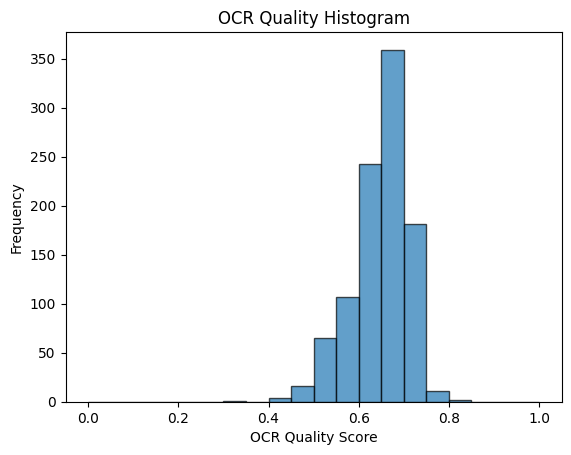

In [16]:
ocr_quality_scores = calculate_ocr_quality(texts)
plot_ocr_quality_histogram(ocr_quality_scores)

<br/>

## Exercise 2.1

Update the histogram to plot the OCR quality from the Cook County data and the SEC Edgar data separately. Are there differences in the distributions? If so, why may this be?

<br/><br/>

We can further look at the OCR confidence metrics from tesseract itself and do a similar analysis. 

*Note*: This analysis will only apply to the PDFs, and not the data from SEC Edgar.

In [17]:
def read_xlsx_files(folder_path: str):
    """
    Behavior: Reads text from a folder of .xlsx files

    Parameters:
    - folder_path (str): Path to the folder containing .xlsx files

    Returns:
    - xlsx_dfs (list): List of pandas dataframes, where each dataframe is the contents the OCR positions and confidence levels
    """
    xlsx_dfs = []
    files = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".xlsx"):
            file_path = os.path.join(folder_path, filename)
            df = pd.read_excel(file_path, engine='openpyxl')
            files.append(filename)
            xlsx_dfs.append(df)

    return xlsx_dfs, files

def extract_ocr_conf(xlsx_dfs: List):
    """
    Behavior: Calculates an OCR confidence score from tesseract values

    Parameters:
    - xlsx_dfs (list): List of dataframes containing OCR scores

    Returns:
    - ocr_conf_scores (list): List of average OCR confidence scores, ranging from 0 to 100, for each document
    """
    ocr_conf_scores = []
    ocr_conf_scores_doc_avg = []
    
    for df in xlsx_dfs:
        for conf in df['conf'][df['conf']>0].values:
            ocr_conf_scores.append(conf)
        ocr_conf_scores_doc_avg.append(np.mean(df['conf'][df['conf']>0].values))
    return ocr_conf_scores_doc_avg

def plot_ocr_conf_histogram(ocr_conf_scores: List):
    """
    Behavior: Plots a histogram of OCR quality scores

    Parameters:
    - ocr_quality_scores (list): List of average OCR confidence scores, ranging from 0 to 100, for each document

    Returns: None
    """
    # Check if OCR quality scores are provided
    if not ocr_conf_scores:
        print("Error: No OCR quality scores provided.")
        return

    # Plot the histogram
    plt.hist(ocr_conf_scores, bins=20, range=(0, 100), edgecolor='black', alpha=0.7)
    
    # Set labels and title
    plt.title('OCR Tesseract Confidence Histogram')
    plt.xlabel('OCR Tesseract Confidence Score')
    plt.ylabel('Frequency')

    # Show the plot
    plt.show()

*Note* This will also take time to execute

In [18]:
folder_path = os.path.join(HOME_DIRECTORY, "data", "data_text")
xlsx_dfs, filenames = read_xlsx_files(folder_path)a

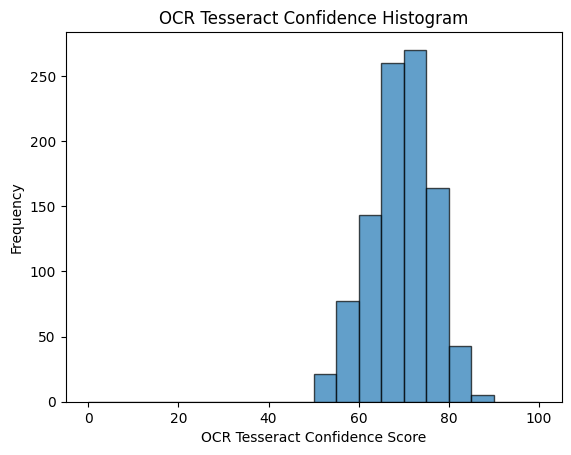

In [19]:
ocr_conf_scores = extract_ocr_conf(xlsx_dfs)
plot_ocr_conf_histogram(ocr_conf_scores)

<br/><br/>

Let's look more closely at a couple lower quality examples:

In [20]:
df_qual = pd.DataFrame([filenames, ocr_quality_scores, ocr_conf_scores]).T
df_qual.columns = ['Filename', 'OCR Qual', 'OCR Conf']

df_qual[df_qual['OCR Qual']<.45]

,Filename,OCR Qual,OCR Conf
0,00010J1Z.pdf.xlsx,0.417289,69.868885
1,000030LG.pdf.xlsx,0.32,71.628654
36,{3FA268E9-1763-4F99-A55F-CC66ED01491A}.pdf.xlsx,0.447531,53.864115
173,00003C1K.pdf.xlsx,0.448598,69.840739
885,{81894B10-8DFB-4EF3-9A80-A93ED1B71E9B}.pdf.xlsx,0.434202,70.33078


In [21]:
df_qual[df_qual['OCR Conf']<55].head()

,Filename,OCR Qual,OCR Conf
36,{3FA268E9-1763-4F99-A55F-CC66ED01491A}.pdf.xlsx,0.447531,53.864115
39,00003FM4.pdf.xlsx,0.682384,52.485141
73,{B1B650C7-4966-4BD0-8030-4A817E78A274}.pdf.xlsx,0.642458,54.149174
133,000030S5.pdf.xlsx,0.68855,54.546804
139,{F9B25CB4-526F-45B9-B0E8-145A3CF9D002}.pdf.xlsx,0.712894,53.230855


In [22]:
filename = '00010J1Z.pdf.txt'
with open(os.path.join(HOME_DIRECTORY, 'data', 'data_text', filename), 'r', encoding='utf-8') as file:
    text = file.read()

text

'Modification Summary Report\n\nContract (PO) Number: 15966\n\nModification Revision Numb\n\nSpecification Number: 53021\n\n‘Name of Contractor: HOMER L. CHASTAIN ASSOC, LLP\n\nCity Department: CHICAGO DEPARTMENT OF TRANSPORTATION\nProfessional Construction Engineering Services Roadway\n\nTitle of Contract: Construction Servises for Grand Avenue [V = Lamon Avenue\nto Pulaski Road\n\n‘Mod Rea Number ‘Mod Reason ‘Description\n‘sere pesos\nssa Bical rie,\n\nStart Date: 4/1/2010\nEnd Date: 6/30/2012\n\nProcurement Services Contact Person: BRENDA CHAGOYA,\n\nPlease refer tothe DPS website for Contact information under "Doing Business With The City\n\nVendor Number: 158004\nSubmission Date.\npec 82\n\nAmesdmer \'\n\nVendor No 18008\nSpec. No: s302t\n(Conact No. (“Agreement”) 13966\nConstant Homer L. Chastain and Asoc,\nCurent Contact Value: $525,17541\nThis Adjustment S$ 99,39852\nAdjusted Contract Value: 86147393\n\nAMENDMENT #1\n\n‘This amendment (“Amendment”) is made and entered into as o

In [23]:
filename = '{3FA268E9-1763-4F99-A55F-CC66ED01491A}.pdf.txt'
with open(os.path.join(HOME_DIRECTORY, 'data', 'data_text', filename), 'r', encoding='utf-8') as file:
    text = file.read()

text

'Modification Summary Report\n\nContract PO) Number: 41200\n“Modification Revision Number: 7\n\nSpecification Number: 138104\n\nName of Contractor: PAN-OCEANIC ENGINEERING CO INC\nCity Department: DEPARTMENT OF WATER MANAGEMENT.\n\nTitle of Contra\nAncillary Sewer Construction = South\n\n‘Mod Rea Number ‘Mod Reason Description\n\n303825 DOLLAR AMOUNT CHANGE PONIZODICMAA/PCMEIGIVLI\n\n$6 201,973.66\n\n‘Term of Contract: StartDate: 7/2016 nine\nEnd Date: 12/31/2019\n\nProcurement Services Contact Person: ALVIN JEFFERSON\nPlease refer tothe DPS website for Contact information under "Doing Business With The City"\n\nthas been determined, on behalf ofthe City of Chicago, with regard to this Contract Amendment!\n“Modification, thatthe circumstance suid to necessitate the change in performance were not\nreasonably foreseeable a the time the Agreement was signed, or that the change is germane to the\noriginal Agreement as signed, or thatthe change order isin the best interest ofthe City of Chi

<br/>

As we visually inspect these examples - through the OCR text AND through looking at the original document - we see that though some portions of the document have higher quality, other parts do not. 

These particular examples appear to be PDFs of multiple separate documents that have been combined, with varying levels of quality. Some pages appear "normal", others have a significant amount of handwriting, and other pages are a level of quality that may be hard for even a human to read.

<br/>

<br/>

### Exercise 2.2:

Explore a few of the documents with very high OCR confidence scores. Does your visual inspection agree with the high OCR confidence score that was generated for these documents?

<br/>

<br/>

### Exercise 2.3:

Further explore to assess potential patterns - are there any correlations with document length? What about with document date?

How useful are these measures compared to the rate of dictionary words? Do these measurements provide different information to us?

<br/>

<br/><br/>

## Check Cluster Assignment

Here we pick a few documents from each cluster to explore each cluster's "topic" and see if there is some consistency.

In [24]:
clusters = pd.DataFrame([filenames, cluster_labels]).T
clusters.columns = ['Filename', 'Cluster label']
clusters.head()

,Filename,Cluster label
0,00010J1Z.pdf.xlsx,18
1,000030LG.pdf.xlsx,17
2,00001SJ3.pdf.xlsx,0
3,0000222K.pdf.xlsx,15
4,{31A24C4F-949A-4483-A3E8-E0A238322CA4}.pdf.xlsx,5


In [25]:
clusters[clusters['Cluster label']==4].head(10)

,Filename,Cluster label
16,00010CJ5.pdf.xlsx,4
26,00002B6S.pdf.xlsx,4
32,000037SF.pdf.xlsx,4
33,00003429.pdf.xlsx,4
58,{6BCDBE24-8973-41D1-9378-45E5D96C23E1}.pdf.xlsx,4
70,{C002F876-0000-C615-99CA-3327BB589806}.pdf.xlsx,4
123,{E0281D78-0000-CF17-811D-41261AF9862E}.pdf.xlsx,4
135,00002P9R.pdf.xlsx,4
152,00002TCQ.pdf.xlsx,4
182,{B6F749B0-73CB-4E5B-ACFD-854CA1DFA0FC}.pdf.xlsx,4


<br/>

If we open and explore some of the clusters in cluster group 4, we quickly see the pattern of contract modification documents and delegate agency grant agreement documents.

<br/><br/>

### Exercise 2.4:

We've done some exploration for cluster 4 to examine the documents' consistency within a cluster. As an exercise, repeat for additional cluster numbers to confirm that the cluster makes sense and identify the key "topic" or document pattern in that cluster.

Is there a single "category" that summarizes this cluster? Or multiple types? Does this cluster make cohesive sense (from a human perspective)?

<br/><br/><br/>